# Stain Normalization and Resize

In [1]:
!pip install LBBNorm Pillow Numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.4/92.4 kB 996.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 13.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 14.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 59.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-p

In [2]:
import os
import cv2
import tqdm
import shutil
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from google.colab import drive
from google.colab import files
from LBBNorm import ModifiedReinhard

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Get the pathes of WSI folders that exist in the Drive
temp = os.listdir('/content/drive/MyDrive')
pathes_of_WSI_folders =[]
for path in temp:
  if path.startswith('WSI'):
    pathes_of_WSI_folders.append(path)

In [6]:
pathes_of_WSI_folders

['WSI_Tumor_Pathes_22',
 'WSI_Tumor_Pathes_21',
 'WSI_Tumor_Pathes_20',
 'WSI_Tumor_Pathes_19',
 'WSI_Tumor_Pathes_23']

In [7]:
# Load the image and convert it to a NumPy array
def load_image(image_path):
    with Image.open(image_path) as img:
        img_array = np.array(img)
    return img_array

In [8]:
# A function to resize images to 512*512
def resize(image):

    # Resize to 512*512
    return image.resize((512,512))

In [9]:
# Create an instance of the normalizer
normalizer = ModifiedReinhard()

# Load the target image for fitting
target_image_path = '/content/patch_normal_091_7818.png'
target_image = load_image(target_image_path)

# Fit the normalizer with the target image
normalizer.fit(target_image)

In [10]:
def normalization(image_path):

    # Load the image
    sample = load_image(image_path)

    # Normalize the sample image
    normalized_image = normalizer.transform(sample)

    # Convert to int8
    normalized_image_uint8 = normalized_image.astype(np.uint8)

    return Image.fromarray(normalized_image_uint8)

In [11]:
# A finction for filter tumor patch names
def filterNames(folder_path, threshold):

    filteredNames = []

    # Iterate through all files in the folder
    for filename in os.listdir(folder_path):
        # Check if the file is an image file
        if filename.endswith(('.png', '.jpg', '.jpeg')):

            # Load the image
            image_path = os.path.join(folder_path, filename)
            image = cv2.imread(image_path)

            # Convert the image to grayscale
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            # Count white pixels
            white_pixels = (gray_image == 255).sum()

            # Total pixels
            total_pixels = gray_image.size

            # Calculate the ratio
            white_ratio = white_pixels / total_pixels

            # Check if the white ratio is above the threshold or there is at least one black pixel (background)
            if (white_ratio >= threshold) and ((gray_image == 0).any()== False):
                patchName = filename.replace('mask', 'patch')
                filteredNames.append(patchName)


    return filteredNames

In [12]:
# # check the above function
# filteredImageNames = filterNames('/content/drive/MyDrive/WSI_Tumor_Pathes_1/tumor_masks_1', 0.3)
# print(len(filteredImageNames))
# print(filteredImageNames[0])

In [13]:
# NormalPathes
# Loop through folders
for folderName in pathes_of_WSI_folders:

    # Create a folder in content for saving the final images
    os.makedirs(f'/content/{folderName}/', exist_ok=True)
    folderPath = f'/content/drive/MyDrive/{folderName}'
    temp = os.listdir(folderPath)
    imageNames = os.listdir(f'/content/drive/MyDrive/{folderName}/{temp[0]}')

    # Loop through images
    for img in tqdm.tqdm(imageNames):

        # Stain Normalization
        normalized_image = normalization(f'/content/drive/MyDrive/{folderName}/{temp[0]}/{img}')
        # Resize
        resized_image = resize(normalized_image)
        # Save the final image
        resized_image.save(f'/content/{folderName}/{img}')

    # Save in drive
    shutil.copytree(f'/content/{folderName}', os.path.join(f'/content/drive/MyDrive/Preped_{folderName}', ) )
    print('Saved in Drive!')

---------------------------------------------------------------------------

In [14]:
# TumorPatches
# First filter the images and then do StainNormalization

# Threshold for white ratio (e.g., 30%)
threshold = 0.3

# Loop through folders
for folderName in pathes_of_WSI_folders:

    # Create a folder in content for saving the final images
    os.makedirs(f'/content/{folderName}/', exist_ok=True)
    folderPath = f'/content/drive/MyDrive/{folderName}'
    temp = os.listdir(folderPath)
    imageNames = os.listdir(f'/content/drive/MyDrive/{folderName}/{temp[0]}')


    # Folder containing the masks
    folder_path = f'/content/drive/MyDrive/{folderName}/{temp[1]}'

    # Threshold for white ratio (e.g., 30%)
    threshold = 0.3

    # Count masks meeting either condition and the total number of images
    filteredImageNames = filterNames(folder_path, threshold)


    # Loop through images
    for img in tqdm.tqdm(filteredImageNames):

        # Stain Normalization
        normalized_image = normalization(f'/content/drive/MyDrive/{folderName}/{temp[0]}/{img}')
        # Resize
        resized_image = resize(normalized_image)
        # Save the final image
        resized_image.save(f'/content/{folderName}/{img}')

    # Save in Drive
    shutil.copytree(f'/content/{folderName}', os.path.join(f'/content/drive/MyDrive/Preped_{folderName}', ) )
    print('Saved in Drive!')

100%|██████████| 521/521 [11:23<00:00,  1.31s/it]


Saved in Drive!


100%|██████████| 321/321 [06:19<00:00,  1.18s/it]


Saved in Drive!


100%|██████████| 1035/1035 [20:55<00:00,  1.21s/it]


Saved in Drive!


100%|██████████| 2353/2353 [46:44<00:00,  1.19s/it]


Saved in Drive!


100%|██████████| 2082/2082 [46:50<00:00,  1.35s/it]


Saved in Drive!


_________________________________________________________________________________________

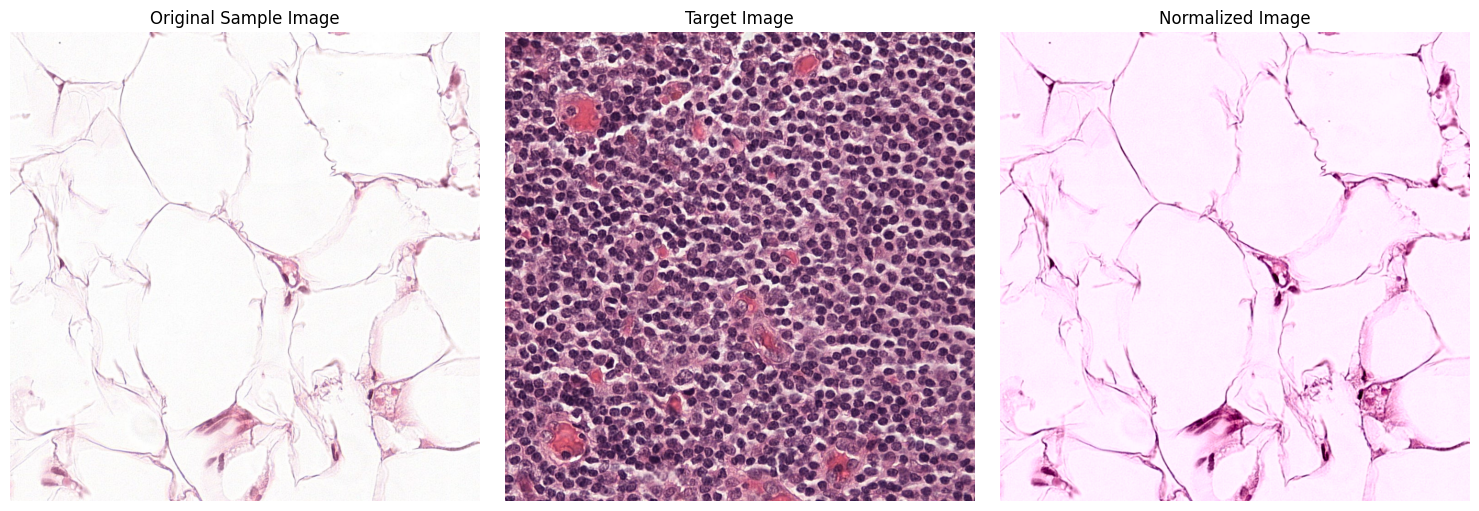

In [ ]:
# Load images for display
# Ensure Matplotlib plots inline (for Jupyter Notebook/Colab)
%matplotlib inline

normalized_image_path = '/content/WSI_Normal_Patches_2/patch_normal_011_10171.png'
sample_image = Image.open('/content/drive/MyDrive/WSI_Normal_Patches_2/normal_patches_2/patch_normal_011_10171.png')
target_image_display = Image.open('/content/patch_normal_091_7818.png')
normalized_image_display = Image.open(normalized_image_path)

# Display all three images horizontally
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(sample_image)
axes[0].set_title('Original Sample Image')
axes[0].axis('off')

axes[1].imshow(target_image_display)
axes[1].set_title('Target Image')
axes[1].axis('off')

axes[2].imshow(normalized_image_display)
axes[2].set_title('Normalized Image')
axes[2].axis('off')

plt.tight_layout()
plt.show()